## Example 1

https://pyabc.readthedocs.io/en/latest/examples/parameter_inference.html

In [5]:
import os
import tempfile
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pyabc
from scipy.stats import uniform, randint
from epydemix.calibration import ABCSampler

In [6]:
def model(parameter):
    return {"data": parameter["mu"] + 0.5 * np.random.randn()}

def distance(simulation, data):
    return abs(simulation["data"] - data["data"])

In [7]:
## Pyabc calibration
prior = pyabc.Distribution(mu=pyabc.RV("uniform", 0, 5))
abc = pyabc.ABCSMC(model, prior, distance, population_size=100)

db_path = os.path.join(tempfile.gettempdir(), "test.db")
observation = 2.5
abc.new("sqlite:///" + db_path, {"data": observation})

history = abc.run(minimum_epsilon=0.1, max_nr_populations=10)

ABC.Sampler INFO: Parallelize sampling on 8 processes.
ABC.History INFO: Start <ABCSMC id=9, start_time=2025-04-09 08:52:05>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.07781927e+00.
ABC INFO: Accepted: 100 / 220 = 4.5455e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 5.54194272e-01.
ABC INFO: Accepted: 100 / 258 = 3.8760e-01, ESS: 9.5277e+01.
ABC INFO: t: 2, eps: 2.81680659e-01.
ABC INFO: Accepted: 100 / 331 = 3.0211e-01, ESS: 9.0013e+01.
ABC INFO: t: 3, eps: 1.38778687e-01.
ABC INFO: Accepted: 100 / 643 = 1.5552e-01, ESS: 4.6812e+01.
ABC INFO: t: 4, eps: 6.82491713e-02.
ABC INFO: Accepted: 100 / 1622 = 6.1652e-02, ESS: 9.1226e+01.
ABC INFO: Stop: Minimum epsilon.
ABC.History INFO: Done <ABCSMC id=9, duration=0:00:53.871352, end_time=2025-04-09 08:52:58>


In [8]:
## Epydemix calibration
prior = {"mu": uniform(0, 5)}
abc_epydemix = ABCSampler(model, prior, {}, observation, distance)

results = abc_epydemix.calibrate(strategy="smc", num_generations=10, minimum_epsilon=0.1, num_particles=100)

Starting ABC-SMC with 100 particles and 10 generations

Generation 1/10 (epsilon: inf)
	Accepted 100/100 (acceptance rate: 100.00%)
	Elapsed time: 00:00:00

Generation 2/10 (epsilon: 1.310570)
	Accepted 100/173 (acceptance rate: 57.80%)
	Elapsed time: 00:00:01

Generation 3/10 (epsilon: 0.633677)
	Accepted 100/294 (acceptance rate: 34.01%)
	Elapsed time: 00:00:01

Generation 4/10 (epsilon: 0.240205)
	Accepted 100/513 (acceptance rate: 19.49%)
	Elapsed time: 00:00:01

Generation 5/10 (epsilon: 0.129760)
	Accepted 100/879 (acceptance rate: 11.38%)
	Elapsed time: 00:00:01

Generation 6/10 (epsilon: 0.064287)
	Accepted 100/1772 (acceptance rate: 5.64%)
	Elapsed time: 00:00:02
Minimum epsilon reached


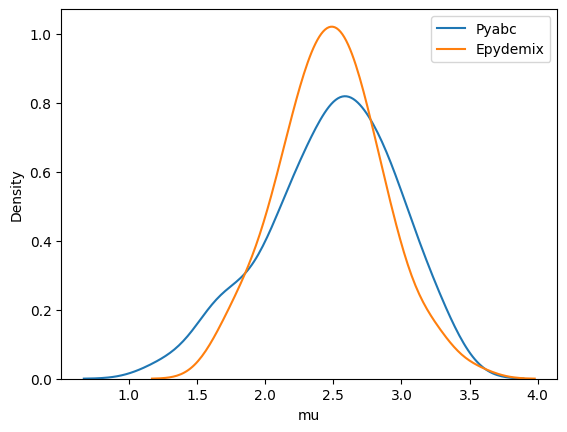

In [9]:
posterior_pyabc = history.get_distribution()[0]
posterior_epydemix = results.get_posterior_distribution()

sns.kdeplot(posterior_pyabc["mu"], label="Pyabc")
sns.kdeplot(posterior_epydemix["mu"], label="Epydemix")
plt.legend()
plt.show()


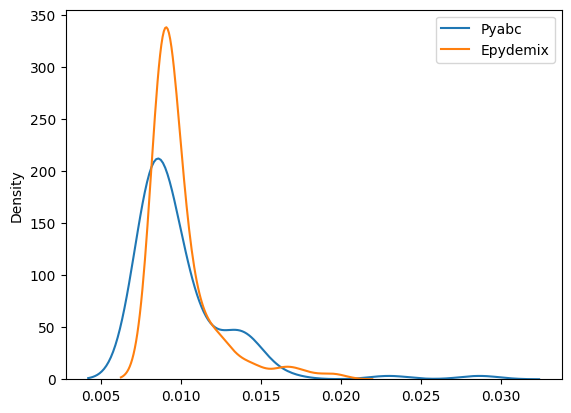

In [10]:
weights_pyabc = history.get_distribution()[1]
weights_epydemix = results.get_weights()    
sns.kdeplot(weights_pyabc, label="Pyabc")
sns.kdeplot(weights_epydemix, label="Epydemix")
plt.legend()
plt.show()

## Example 2

https://pyabc.readthedocs.io/en/latest/examples/discrete_parameters.html

In [11]:
n_data = 100

def model(p):
    return {
        'data': p['p_discrete']
        + np.random.choice([-2, 0, 2], p=[0.2, 0.5, 0.3])
        + p['p_continuous'] * np.random.normal(size=n_data)
    }


distance = lambda simulation, data: sum((simulation['data'] - data['data']) ** 2)
p_true = {'p_discrete': 2, 'p_continuous': 0.5}
obs = model(p_true)

In [12]:
# domain of possible discrete values
discrete_domain = np.arange(7)

# priors
prior = pyabc.Distribution(
    p_discrete=pyabc.RV('rv_discrete', values=(discrete_domain, [1 / 7] * 7)),
    p_continuous=pyabc.RV('uniform', 0, 2),
)

# transition kernels
transition = pyabc.AggregatedTransition(
    mapping={
        'p_discrete': pyabc.DiscreteJumpTransition(
            domain=discrete_domain, p_stay=0.7
        ),
        'p_continuous': pyabc.MultivariateNormalTransition(),
    }
)

abc = pyabc.ABCSMC(
    model, prior, distance, transitions=transition, population_size=100
)
abc.new(pyabc.create_sqlite_db_id(), obs)
history = abc.run(max_nr_populations=5)

ABC.Sampler INFO: Parallelize sampling on 8 processes.
ABC.History INFO: Start <ABCSMC id=2, start_time=2025-04-09 08:53:08>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 4.99617371e+02.
ABC INFO: Accepted: 100 / 207 = 4.8309e-01, ESS: 1.0000e+02.
ABC INFO: t: 1, eps: 2.48482018e+02.
ABC INFO: Accepted: 100 / 281 = 3.5587e-01, ESS: 8.6698e+01.
ABC INFO: t: 2, eps: 1.25681814e+02.
ABC INFO: Accepted: 100 / 438 = 2.2831e-01, ESS: 8.9840e+01.
ABC INFO: t: 3, eps: 6.95044444e+01.
ABC INFO: Accepted: 100 / 617 = 1.6207e-01, ESS: 8.9190e+01.
ABC INFO: t: 4, eps: 2.89454696e+01.
ABC INFO: Accepted: 100 / 637 = 1.5699e-01, ESS: 8.9127e+01.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=2, duration=0:00:57.791180, end_time=2025-04-09 08:54:06>


In [13]:
prior = {"p_discrete": randint(0, 7), 
         "p_continuous": uniform(0, 2)}
abc_sampler = ABCSampler(model, prior, {}, obs['data'], distance)

results = abc_sampler.calibrate(strategy="smc", num_generations=6, num_particles=100)

Starting ABC-SMC with 100 particles and 6 generations

Generation 1/6 (epsilon: inf)
	Accepted 100/100 (acceptance rate: 100.00%)
	Elapsed time: 00:00:00

Generation 2/6 (epsilon: 559.904972)
	Accepted 100/224 (acceptance rate: 44.64%)
	Elapsed time: 00:00:01

Generation 3/6 (epsilon: 296.128110)
	Accepted 100/275 (acceptance rate: 36.36%)
	Elapsed time: 00:00:02

Generation 4/6 (epsilon: 138.109709)
	Accepted 100/471 (acceptance rate: 21.23%)
	Elapsed time: 00:00:01

Generation 5/6 (epsilon: 115.485579)
	Accepted 100/513 (acceptance rate: 19.49%)
	Elapsed time: 00:00:01

Generation 6/6 (epsilon: 40.702728)
	Accepted 100/790 (acceptance rate: 12.66%)
	Elapsed time: 00:00:01


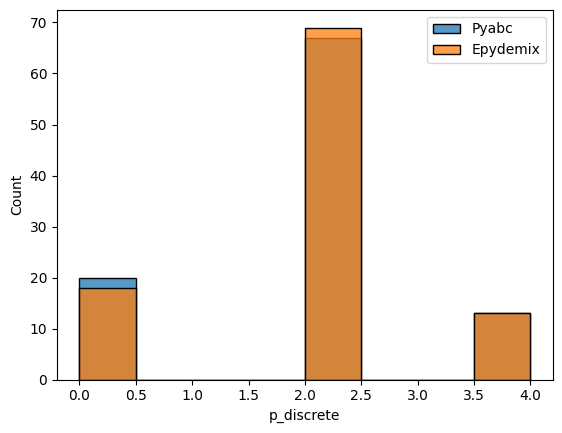

In [14]:
posterior_pyabc = history.get_distribution()[0]
posterior_epydemix = results.get_posterior_distribution()

sns.histplot(posterior_pyabc["p_discrete"], label="Pyabc")
sns.histplot(posterior_epydemix["p_discrete"], label="Epydemix")
plt.legend()
plt.show()


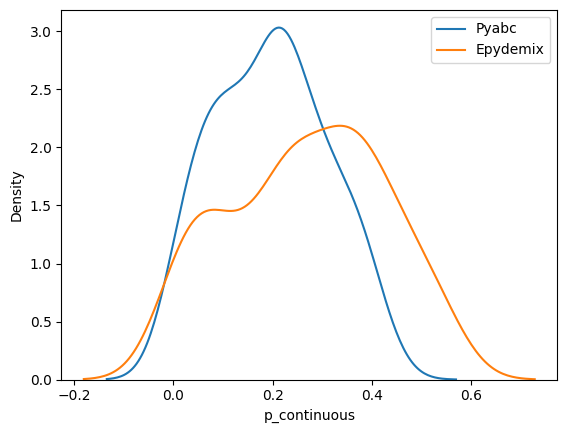

In [15]:
sns.kdeplot(posterior_pyabc["p_continuous"], label="Pyabc")
sns.kdeplot(posterior_epydemix["p_continuous"], label="Epydemix")
plt.legend()
plt.show()